In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
sns.set_theme(context='paper',font_scale=1, style = 'ticks', color_codes='deep')
#plot_kwds = {'alpha' : 0.5, 's' : 100, 'linewidths':0}
#font = {'family' : 'normal','weight' : 'bold','size': 22}
import sys
sys.path.insert(1, "../src")
from _generate_time_series import *
from _clustering import *
import _tracking as tk
from utils_JK import *

from matplotlib.gridspec import GridSpec

%load_ext autoreload
%autoreload 2

In [67]:
# stiffness and mass: 
kx=np.array([2,2])*4000
ky=np.array([1,1])*4000
m=np.array([1,1])*500

n=150  #number of time series to run

base_shapey=np.hstack((np.linspace(
    1,1.3,n//2),np.linspace(1.5,1.3,n-n//2)))
base_shapex=np.sin(2*np.pi*base_shapey*20)*0.03+base_shapey

shapey=np.vstack((base_shapey,base_shapey**2))
shapex=np.vstack((base_shapex,base_shapex**0.5+0.4))

#What modal orders to run in the cov-ssi:
orders=np.arange(2,50,1)

#sampling frequency and lengt of each time series:
fs=7        #Hz
T_max=3000  #sec
t=np.arange(0,T_max,1/fs)

# specify parameters for the load series: 
    # the general input for the amplutide of the white noise
white_noise_amp=1
    # whether or not to create new load series for each time segment
next_segment='new'
    #whether or not to greate indeviduel loadings for all DOFS
next_DOF='new'
    #Whether or not to include a harmonic part in the loading, and what type of 
    #harmonic function
harmonic=None
    #the the factor the amplitude of the harmonic is multiplied with 
    #the amplitude of the white noise
harmonic_part=0.2

### Noise fac for added measurments noice: 
noise_fac=1

#Number of times to run the
n_sim = 40

valid_range= { 'freq': [1e-4, np.inf],'damping': [1e-4,np.inf] }

indicator='freq'
s=1
stabcrit = {'freq':0.05, 'damping': 0.1, 'mac': 0.1}
prob_threshold = 0.5   #probability of pole to belong to 
# cluster, based on estimated "probability" density function

min_cluster_size=35 
min_samples=12
scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0}

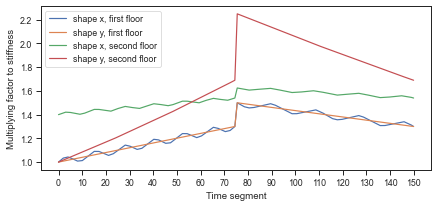

In [69]:
fig,ax = plt.subplots(figsize=(7,3))
ax.plot(np.linspace(0,n,n),shapex[0],label='shape x, first floor')
ax.plot(np.linspace(0,n,n),shapey[0], label='shape y, first floor')
ax.plot(np.linspace(0,n,n),shapex[1],label='shape x, second floor')
ax.plot(np.linspace(0,n,n),shapey[1], label='shape y, second floor')
ax.set_xlabel('Time segment')
ax.set_xticks(np.arange(0, 151, 10))
ax.set_ylabel('Multiplying factor to stiffness')
ax.legend()

In [70]:
true_w,true_phi,responses=generate_dynamic_series(kx,ky,shapex,shapey,m,t,
                                           white_noise_amp=white_noise_amp
                                           ,next_segment=next_segment
                                           ,next_DOF=next_DOF
                                           ,harmonic=harmonic
                                           ,harmonic_part=harmonic_part
                                           ,plot=False)
    
lambds,phis=create_input_COVssi(responses,t,orders)

ys=create_output_guassian(lambds)

til_jon=ys.T

KeyboardInterrupt: 

In [ ]:
phis_out,ws_out=clustering(lambds,
phis,orders,s,stabcrit,valid_range,indicator,prob_threshold,
scaling,min_cluster_size,min_samples,true_w=true_w,plot=False)

In [34]:
id_sort = np.argsort(true_w[0])
true_w_sorted = true_w[:,id_sort]
true_phi_sorted = true_phi[id_sort,:,:]
true_f_sorted = true_w_sorted/(2*np.pi)
freqs_out = radtoHz(ws_out)

In [35]:
np.savez('tracking_figures_mock_data',freqs_out,phis_out)

c:\Users\jonkr\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [3]:
# data = np.load('./tracking_figures_mock_data.npz',allow_pickle=True)
# freqs_out = data['arr_0']
# phis_out = data['arr_1']

In [3]:
data = np.load('../Numerical test case/test_3/test_results_flipped/test_3_run_'+str(4)+'_flipped.npz', allow_pickle=True)
freqs_out = data['arr_0']
phis_out = data['arr_1']

n = 25
m = 10
initial_mode_traces,clusterer = tk.get_initial_modes(phis_initial=phis_out[:n], freqs_inital=freqs_out[:n])
#next_mode_traces = tk.perform_tracking(freqs=freqs_out, phis=phis_out, n=n, m=m, d_track_threshold=0.3)
#print(next_mode_traces)

c:\Users\jonkr\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jonkr\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


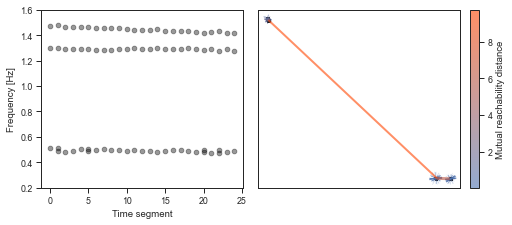

In [5]:
colors = ['C0', 'C1', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

map=sns.color_palette("blend:b,orangered", as_cmap=True)

fig, axis = plt.subplots(1,2,figsize = (7,3), constrained_layout = True)

for k, fk in enumerate(freqs_out[:n]):
    axis[0].scatter(np.ones(fk.shape)*k, fk, color = 'black', alpha = 0.4)

clusterer.minimum_spanning_tree_.plot(axis = axis[1], edge_cmap=map,
                                    edge_alpha=0.6,
                                    node_size=5,
                                    edge_linewidth=2)

# clusterer.condensed_tree_.plot(axis = axis[1,0], select_clusters=True, selection_palette=sns.color_palette(), cmap=map)

# for k, fk in enumerate(freqs_out[:n]):
#     axis[1,1].scatter(np.ones(fk.shape)*k, fk, color = 'black', alpha = 0.4)


axis[0].set_xlabel('Time segment')
axis[0].set_ylabel('Frequency [Hz]')
axis[0].set_ylim([0.2, 1.6])
axis[0].set_xticks(np.arange(0, n+1, 5))

# axis[1,1].set_xlabel('Time segment')
# axis[1,1].set_ylabel('Frequency [Hz]')
# axis[1,1].set_ylim([0, 1.4])
# axis[1,1].set_xticks(np.arange(0, n+1, 5))
# axis[1,1].set_title('Initial Phase: $n = 30$')

fig.savefig('./figures_flipped/initial_phase',dpi = 400, bbox_inches = 'tight')

In [22]:
n = 25
initial_mode_traces,clusterer1, clusterer2 = tk.get_initial_modes2(phis_initial=phis_out[:n], freqs_inital=freqs_out[:n])

In [23]:
freqsHz_above, freqsHz_below, _, _ = divide_modes(freqs_out, phis_out, freq_lim=0.75)

c:\Users\jonkr\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jonkr\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\jonkr\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jonkr\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(-5.0, 0, ''),
 Text(0.0, 0, ''),
 Text(5.0, 0, ''),
 Text(10.0, 0, ''),
 Text(15.0, 0, ''),
 Text(20.0, 0, ''),
 Text(25.0, 0, ''),
 Text(30.0, 0, '')]

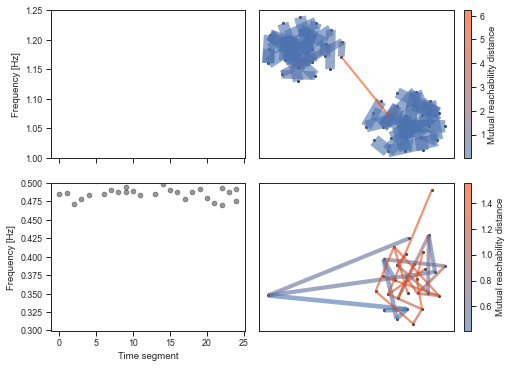

In [16]:
map=sns.color_palette("blend:b,orangered", as_cmap=True)

fig, axis = plt.subplots(2,2,figsize = (7,5), constrained_layout = True, gridspec_kw={'hspace':0.09})

for k, fk in enumerate(freqsHz_above[:n]):
    axis[0,0].scatter(np.ones(fk.shape)*k, fk, color = 'black', alpha = 0.4)

for k, fk in enumerate(freqsHz_below[:n]):
    axis[1,0].scatter(np.ones(fk.shape)*k, fk, color = 'black', alpha = 0.4)

clusterer1.minimum_spanning_tree_.plot(axis = axis[0,1], edge_cmap=map,
                                    edge_alpha=0.6,
                                    node_size=5,
                                    edge_linewidth=2)

clusterer2.minimum_spanning_tree_.plot(axis = axis[1,1], edge_cmap=map,
                                    edge_alpha=0.6,
                                    node_size=5,
                                    edge_linewidth=2)

axis[1,0].set_xlabel('Time segment')
axis[1,0].set_ylabel('Frequency [Hz]')
axis[0,0].set_ylabel('Frequency [Hz]')
axis[1,0].set_ylim([0.3, 0.50])
axis[0,0].set_ylim([1, 1.25])
axis[1,0].set_xticks(np.arange(0, n+1, 5))
axis[0,0].set_xticklabels([])

#fig.savefig('./initial_phase_twosteps', dpi = 400, bbox_inches = 'tight')

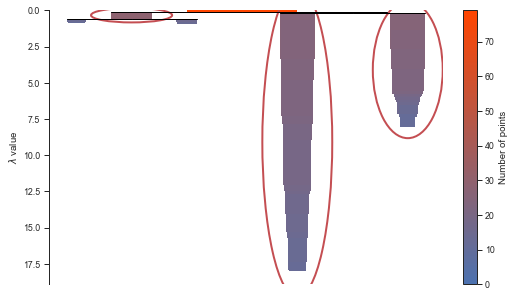

In [30]:
fig, axis = plt.subplots(figsize = (7,4), constrained_layout = True)


clusterer.condensed_tree_.plot(axis = axis, cmap=map, select_clusters=True)

fig.savefig('./figures_flipped/mutual_reachability_graph_initial_phase', dpi = 400, bbox_inches = 'tight')

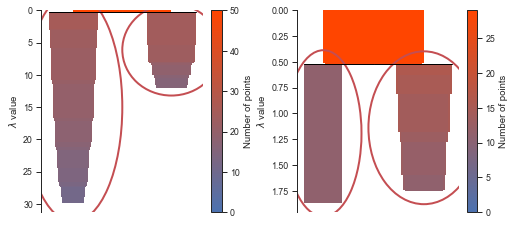

In [31]:
fig, axis = plt.subplots(1,2,figsize = (7,3), constrained_layout = True)

clusterer1.condensed_tree_.plot(axis = axis[0], cmap=map, select_clusters=True)

clusterer2.condensed_tree_.plot(axis = axis[1], cmap=map, select_clusters=True)

fig.savefig('./figures_flipped/mutual_reachability_graph_initial_phase_split', dpi = 400, bbox_inches = 'tight')

In [35]:
# data = np.load('../Numerical test case/test_3/test_results/test_3_true.npz', allow_pickle=True)
# true = data['arr_0']
# phis_out = data['arr_1']

data = np.load('../Numerical test case/test_3/test_results_flipped/test_3_run_'+str(1)+'_flipped.npz', allow_pickle=True)
freqs_out = data['arr_0']
phis_out = data['arr_1']

n = 30
m = 15
initial_mode_traces = tk.get_initial_modes2(phis_initial=phis_out[:n], freqs_inital=freqs_out[:n])
next_mode_traces = tk.perform_tracking(freqs=freqs_out[:n+m], phis=phis_out[:n+m], n=n, m=m, d_track_threshold=0.3,split=True)
#print(next_mode_traces)

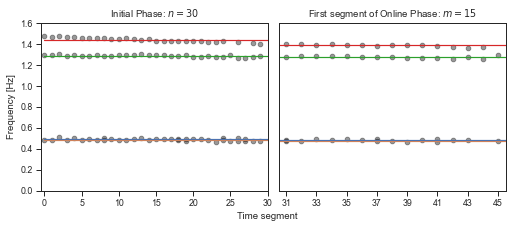

In [41]:
colors = ['C1', 'C0', 'tab:green','tab:red', 'tab:purple', 'tab:brown']

fig, axis = plt.subplots(1, 2, figsize = (7,3), constrained_layout = True)

for k, fk in enumerate(freqs_out[:n]):
    axis[0].scatter(np.ones(fk.shape[0])*k, fk, color = 'black', alpha = 0.4)

for i, mode_trace in enumerate(initial_mode_traces):
    axis[0].plot([0, n], [mode_trace.ref_frequency, mode_trace.ref_frequency], color = colors[i])

for k, fk in enumerate(freqs_out[n:n+m+1]):
    axis[1].scatter(np.ones(fk.shape[0])*k+n, fk, color = 'black', alpha = 0.4)

for i, next_mode_trace in enumerate(next_mode_traces):
    axis[1].plot([n+1-0.5, n+m+1-0.5], [next_mode_trace.ref_frequency, next_mode_trace.ref_frequency], color = colors[i])

axis[0].set_xlabel('Time segment', y = 1, x = 1)
axis[0].set_ylabel('Frequency [Hz]')
axis[0].set_xlim([-0.5, 9.5])
axis[0].set_ylim([0, 1.6])
axis[1].set_ylim([0, 1.6])
axis[0].set_xticks(np.arange(0, n+1, 5))
axis[1].set_xlim((n+1-0.5, n + m+1-0.5))
axis[1].set_xticks(np.arange(n+1, n+m+1,2))
axis[0].set_title('Initial Phase: $n = 30$')
axis[1].set_title('First segment of Online Phase: $m = 15$')
axis[1].tick_params(axis = 'y', left = False, which = 'both', labelleft = False)

fig.savefig('./figures_flipped/first_tracking_figure', dpi = 400, bbox_inches = 'tight')


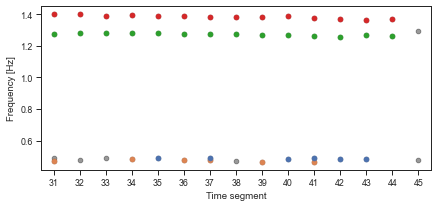

In [44]:
fig, axis = plt.subplots(figsize=(7,3))

for k, fk in enumerate(freqs_out):
    if k > n and k < n + m + 1:
        axis.scatter(np.ones_like(fk)*k, fk, color = 'black' ,alpha = 0.4)

for i, mode_trace in enumerate(next_mode_traces):
    axis.scatter(np.array(mode_trace.time_seg)[1:m+5],np.array(mode_trace.frequencies)[1:m+5], color = colors[i])

axis.set_xlim((n+1-0.5, n + m+1-0.5))
axis.set_xlabel('Time segment')
axis.set_ylabel('Frequency [Hz]')
axis.set_xticks(np.arange(n+1, n+m+1))

#fig.savefig('./figures_flipped/second_tracking_figure', dpi = 400, bbox_inches = 'tight')

In [3]:
freqs = np.array([[0.5, 0.8], [0.42, 0.52, 0.65], [0.41, 0.49, 0.64]], dtype = object)

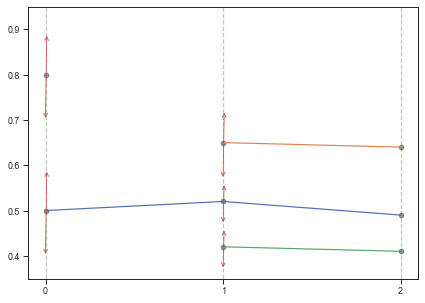

In [5]:
fig, axs = plt.subplots(figsize = (7, 5))

for k, fk in enumerate(freqs):
    axs.scatter(np.ones_like(fk)*k, fk, color = 'black', alpha = 0.4)

axs.annotate(text = ' ',xy=(0, freqs[0][0]-0.1), xytext=(0, freqs[0][0]+0.1),
        arrowprops=dict(arrowstyle='<->', color='r'))

axs.annotate(text = ' ',xy=(0, freqs[0][1]-0.1), xytext=(0, freqs[0][1]+0.1),
        arrowprops=dict(arrowstyle='<->', color='r'))

axs.plot([0, 0], [0, 1], linestyle = 'dashed', color = 'darkgreen', alpha = 0.3)
axs.plot([1, 1], [0, 1], linestyle = 'dashed', color = 'darkgreen', alpha = 0.3)
axs.plot([2, 2], [0, 1], linestyle = 'dashed', color = 'darkgreen', alpha = 0.3)

axs.plot([0, 1], [freqs[0][0], freqs[1][1]], color = 'C0')
axs.plot([1, 2], [freqs[1][1], freqs[2][1]], color = 'C0')

axs.plot([1, 2], [freqs[1][2], freqs[2][2]], color = 'C1')

axs.plot([1, 2], [freqs[1][0], freqs[2][0]], color = 'C2')

axs.annotate(text = ' ',xy=(1, freqs[1][2]-0.08), xytext=(1, freqs[1][2]+0.08),
        arrowprops=dict(arrowstyle='<->', color='r'))

axs.annotate(text = ' ',xy=(1, freqs[1][1]-0.05), xytext=(1, freqs[1][1]+0.05),
        arrowprops=dict(arrowstyle='<->', color='r'))

axs.annotate(text = ' ',xy=(1, freqs[1][0]-0.05), xytext=(1, freqs[1][0]+0.05),
        arrowprops=dict(arrowstyle='<->', color='r'))


axs.set_ylim((0.35, 0.95))
axs.set_xticks(np.arange(3))

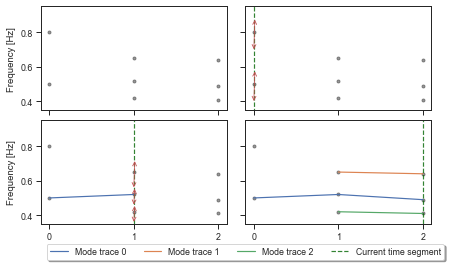

In [4]:
fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(2,2, hspace=0.1, wspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)


axs[1,0].plot([0, 1], [freqs[0][0], freqs[1][1]], color = 'C0')
axs[1,1].plot([0, 1], [freqs[0][0], freqs[1][1]], color = 'C0')
axs[1,1].plot([1, 2], [freqs[1][1], freqs[2][1]], color = 'C0', label = 'Mode trace 0')

axs[1,1].plot([1, 2], [freqs[1][2], freqs[2][2]], color = 'C1', label = 'Mode trace 1')

axs[1,1].plot([1, 2], [freqs[1][0], freqs[2][0]], color = 'C2', label = 'Mode trace 2')

axs[1,0].annotate(text = ' ',xy=(1, freqs[1][2]-0.1), xytext=(1, freqs[1][2]+0.1),
        arrowprops=dict(arrowstyle='<->', color='r'))

axs[1,0].annotate(text = ' ',xy=(1, freqs[1][1]-0.07), xytext=(1, freqs[1][1]+0.07),
        arrowprops=dict(arrowstyle='<->', color='r'))

axs[1,0].annotate(text = ' ',xy=(1, freqs[1][0]-0.07), xytext=(1, freqs[1][0]+0.07),
        arrowprops=dict(arrowstyle='<->', color='r'))

for k, fk in enumerate(freqs):
    axs[0,0].scatter(np.ones_like(fk)*k, fk, color = 'black' ,alpha = 0.4, s = 10)
    axs[0,1].scatter(np.ones_like(fk)*k, fk, color = 'black' ,alpha = 0.4, s = 10)
    axs[1,0].scatter(np.ones_like(fk)*k, fk, color = 'black' ,alpha = 0.4, s = 10)
    axs[1,1].scatter(np.ones_like(fk)*k, fk, color = 'black' ,alpha = 0.4, s = 10)

axs[0,1].annotate(text = ' ',xy=(0, freqs[0][0]-0.11), xytext=(0, freqs[0][0]+0.11),
        arrowprops=dict(arrowstyle='<->', color='r'))

axs[0,1].annotate(text = ' ',xy=(0, freqs[0][1]-0.11), xytext=(0, freqs[0][1]+0.11),
        arrowprops=dict(arrowstyle='<->', color='r'))

axs[0,1].plot([0, 0], [0, 1], linestyle = 'dashed', color = 'darkgreen', alpha = 0.8)
axs[1,0].plot([1, 1], [0, 1], linestyle = 'dashed', color = 'darkgreen', alpha = 0.8)
axs[1,1].plot([2, 2], [0, 1], linestyle = 'dashed', color = 'darkgreen', alpha = 0.8, label = 'Current time segment')


axs[0,0].set_ylim((0.35, 0.95))
axs[0,0].set_xticks(np.arange(3))
axs[0,0].set_ylabel('Frequency [Hz]')
axs[1,0].set_ylabel('Frequency [Hz]')
axs[1,0].set_xlabel('Time segment')
axs[1,1].set_xlabel('Time segment')

axs[1,1].legend(loc='upper center', bbox_to_anchor=(0, -0.15),
          fancybox=True, shadow=True, ncol=4)

fig.savefig('./CTD', dpi = 400, bbox_inches = 'tight')

### Cabboi thresholds not good for MTC2

In [143]:
np.random.seed(2)

t = np.arange(0, 200, 1)

freqsHz_high_variance = np.ones_like(t)*0.5 + np.random.normal(loc=0, scale = 0.05, size = t.shape[0]) + np.linspace(0, 0.2, t.shape[0])

# freqsHz_high_variance[:t.shape[0]//2] += 0.1*np.ones(t.shape[0]//2)
# freqsHz_high_variance[t.shape[0]//2:] -= 0.1*np.ones(t.shape[0]//2)
                                                                                                                                                       

In [144]:
def dfmax(dhf, k):
    return np.sqrt(np.std(dhf)*(1 + 1/(np.log(k))))

<bound method Figure.show of <Figure size 1080x720 with 1 Axes>>

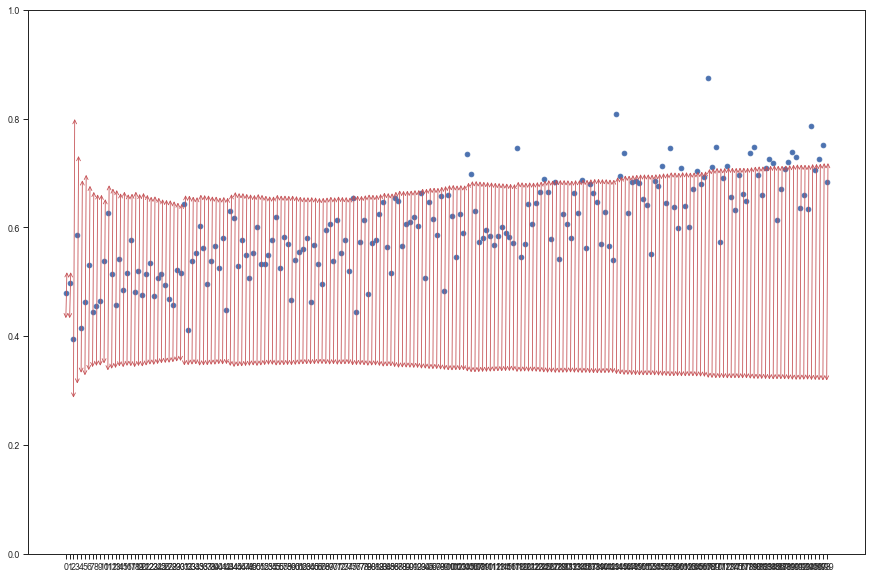

In [145]:
fig, ax = plt.subplots(figsize = (15,10))

ax.scatter(t, freqsHz_high_variance)

ax.set_ylim(0,1)
ax.set_xticks(np.arange(0, t.shape[0], 1))

ax.annotate(text = ' ',xy=(t[0], freqsHz_high_variance[0]-0.05), xytext=(t[0], freqsHz_high_variance[0]+0.05),
        arrowprops=dict(arrowstyle='<->', color='r'))

ax.annotate(text = ' ',xy=(t[1], freqsHz_high_variance[0]-0.05), xytext=(t[1], freqsHz_high_variance[0]+0.05),
        arrowprops=dict(arrowstyle='<->', color='r'))


dhf_list = np.array([])
for i,ti in enumerate(t):
    if i == 0: continue
    dhf = rel_diff(freqsHz_high_variance[0], freqsHz_high_variance[i])
    dhf_list = np.append(dhf_list, dhf)
    if i > 1:
        dfmaxi = dfmax(dhf_list, i)
        ax.annotate(text = ' ',xy=(t[i], freqsHz_high_variance[0]*(1-dfmaxi)), xytext=(t[i], freqsHz_high_variance[0]/(1-dfmaxi)),
                arrowprops=dict(arrowstyle='<->', color='r'))

fig.show

[3.81972979e-02 1.75226423e-01 1.80959538e-01 1.35264841e-01
 2.29223906e-01 1.15612444e-01 2.59471338e-01 2.42202602e-01
 2.28129876e-01 1.09673297e-01 3.48694286e-02 1.48566596e-01
 2.42908410e-01 1.04042231e-01 2.00984070e-01 1.51823941e-01
 5.18593748e-02 2.08509595e-01 1.44541486e-01 2.18433453e-01
 1.57560723e-01 1.22018519e-01 2.22566972e-01 1.67579575e-01
 1.61101915e-01 1.92265048e-01 2.35561523e-01 2.53007727e-01
 1.47775184e-01 1.59923435e-01 4.30412134e-02 3.32712099e-01
 1.23985102e-01 1.01400451e-01 2.51462777e-02 9.28410023e-02
 1.99996018e-01 1.30147817e-01 8.46953526e-02 1.55809544e-01
 6.69187406e-02 2.77674557e-01 1.34011285e-02 6.00417500e-03
 1.52428241e-01 7.48698695e-02 1.18437547e-01 1.87165354e-01
 1.12026684e-01 4.03710490e-02 1.49188700e-01 1.47148518e-01
 1.21466058e-01 7.92559417e-02 1.44460160e-02 1.65094140e-01
 7.25245811e-02 9.41855822e-02 2.57699950e-01 1.44840879e-01
 1.20495264e-01 1.11547911e-01 8.09720747e-02 2.66978361e-01
 1.03936315e-01 1.594889

<bound method Figure.show of <Figure size 1080x720 with 1 Axes>>

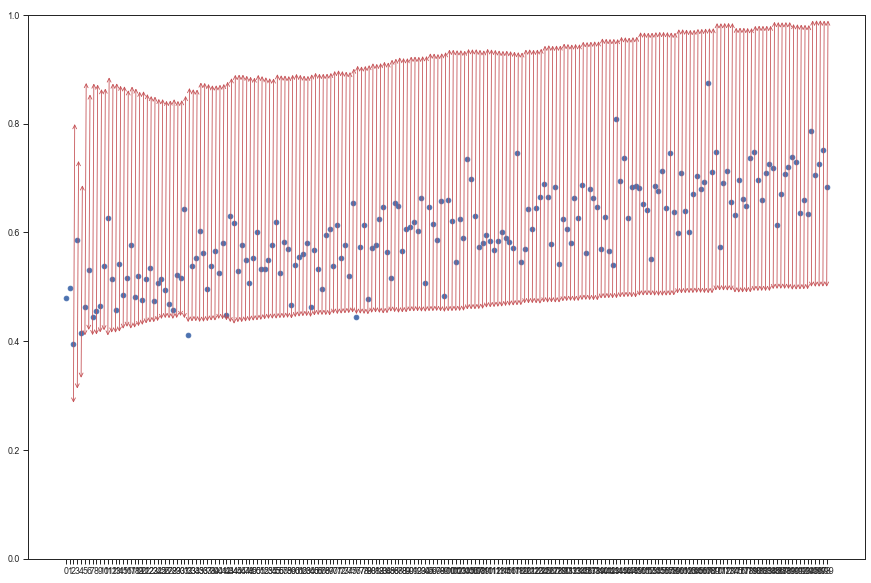

In [146]:
fig, ax = plt.subplots(figsize = (15,10))

ax.scatter(t, freqsHz_high_variance)

ax.set_ylim(0,1)
ax.set_xticks(np.arange(0, t.shape[0], 1))

ax.annotate(text = ' ',xy=(t[0], freqsHz_high_variance[0]-0.5), xytext=(t[0], freqsHz_high_variance[0]+0.5),
        arrowprops=dict(arrowstyle='<->', color='r'))

ax.annotate(text = ' ',xy=(t[1], freqsHz_high_variance[0]-0.5), xytext=(t[1], freqsHz_high_variance[0]+0.5),
        arrowprops=dict(arrowstyle='<->', color='r'))

m = 5

ref_freqs = np.array([freqsHz_high_variance[0]])

dhf_list = np.array([])
for i,ti in enumerate(t):
    if i == 0: continue
    if i%m == 0:
        ref_freqs = np.append(ref_freqs, np.mean(freqsHz_high_variance[i-m:]))

    dhf = rel_diff(ref_freqs[-1], freqsHz_high_variance[i])
    dhf_list = np.append(dhf_list, dhf)
    if i > 1:
        dfmaxi = dfmax(dhf_list, i) 
        ax.annotate(text = ' ',xy=(t[i], (ref_freqs[-1]*(1-dfmaxi))), xytext=(t[i], (ref_freqs[-1]/(1-dfmaxi))),
                        arrowprops=dict(arrowstyle='<->', color='r'))


print(dhf_list)

fig.show